# Gaussian Process Regression

This notebook, I will go over how we can implement the Gaussian process (GP) regression algorithm using Jax. This isn't a new algorithm or anything but I would like to get accustomed to using Jax because it will be useful later when I implement the GPs to handle uncertain inputs.

**Inspirations**

* [Github Code](https://github.com/lucasrm25/Structured-Learning-for-Robot-Control/blob/master/GP/jaxGP.py) - [Lucas](https://www.linkedin.com/in/lucas-rath/?originalSubdomain=bo)
> Broke down the GP function very nicely. Nice enough for me to follow.

## Imports

In [2]:
import sys
from pyprojroot import here
sys.path.append(str(here()))
import pathlib
FIG_PATH = pathlib.Path(str(here())).joinpath('figures/jaxgp/examples/standard/')

import functools
from typing import Callable, Dict, Tuple
import argparse
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
# sns.set_style('whitegrid')
# sns.set_context('talk')
sns.set_context(context="talk", font_scale=0.7)

import numpy as onp
import tqdm
from jax.experimental import optimizers

from src.models.jaxgp.data import get_data, near_square_wave
from src.models.jaxgp.exact import predictive_mean, predictive_variance
from src.models.jaxgp.kernels import gram, rbf_kernel, ard_kernel
from src.models.jaxgp.loss import marginal_likelihood
from src.models.jaxgp.mean import zero_mean
from src.models.jaxgp.utils import cholesky_factorization, get_factorizations, saturate

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers
import numpy as np
import numpy as onp

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

## Data

In [4]:
from dataclasses import dataclass

@dataclass
class args:
    num_train = 80
    num_test = 1_000
    smoke_test = False
    input_noise = 0.3
    output_noise = 0.15
    
# sigma_inputs = 0.15
input_cov = jnp.array([args.input_noise]).reshape(-1, 1)
X, y, Xtest, ytest = near_square_wave(
    n_train=args.num_train,
    input_noise=args.input_noise,
    output_noise=args.output_noise,
    n_test=args.num_test,
)

/home/emmanuel/.conda/envs/egp/lib/python3.8/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Model

In [5]:
# PRIOR FUNCTIONS (mean, covariance)
mu_f = zero_mean
cov_f = functools.partial(gram, ard_kernel)
gp_priors = (mu_f, cov_f)

# Kernel, Likelihood parameters
params = {
    # "gamma": 2.0,
    "length_scale": 1.0,
    "var_f": 1.0,
    "likelihood_noise": 1.0,
}
# saturate parameters with likelihoods
params = saturate(params)

# LOSS FUNCTION
mll_loss = jax.jit(functools.partial(marginal_likelihood, gp_priors))

# GRADIENT LOSS FUNCTION
dloss = jax.jit(jax.grad(mll_loss))

## Optimizer

In [6]:
# STEP FUNCTION
@jax.jit
def step(params, X, y, opt_state):
    # calculate loss
    loss = mll_loss(params, X, y)

    # calculate gradient of loss
    grads = dloss(params, X, y)

    # update optimizer state
    opt_state = opt_update(0, grads, opt_state)

    # update params
    params = get_params(opt_state)

    return params, opt_state, loss

## Training

In [7]:
# TRAINING PARARMETERS
n_epochs = 500 if not args.smoke_test else 2
learning_rate = 0.01
losses = list()

# initialize optimizer
opt_init, opt_update, get_params = optimizers.rmsprop(step_size=learning_rate)

# initialize parameters
opt_state = opt_init(params)

# get initial parameters
params = get_params(opt_state)

postfix = {}

with tqdm.trange(n_epochs) as bar:

    for i in bar:
        # 1 step - optimize function
        params, opt_state, value = step(params, X, y, opt_state)

        # update params
        postfix = {}
        for ikey in params.keys():
            postfix[ikey] = f"{jax.nn.softplus(params[ikey]):.2f}"

        # save loss values
        losses.append(value.mean())

        # update progress bar
        postfix["Loss"] = f"{onp.array(losses[-1]):.2f}"
        bar.set_postfix(postfix)
        # saturate params
        params = saturate(params)

  0%|          | 0/500 [00:00<?, ?it/s]DEBUG:absl:Compiling gram for args (AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit()).
DEBUG:absl:Compiling marginal_likelihood for args (AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit()).
DEBUG:absl:Compiling <unnamed wrapped function> for args (AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit(), AbstractUnit()).
DEBUG:absl:Compiling step for args (ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[80,1]), ShapedArray(float32[80,1]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[]), ShapedArray(float32[])).
100%|██████████| 500/500 [00:11<00:00, 45.09it/s, length_scale=2.56, likelihood_noise=0.05, var_f=0.70, Loss=17.55]


## Predictions

In [27]:
# Posterior Predictions
mu_y = predictive_mean(params, gp_priors, X, y, Xtest)
var_f = predictive_variance(params, gp_priors, X, y, Xtest, False, False)
var_y = predictive_variance(params, gp_priors, X, y, Xtest, True, False)
var_likelihood = var_y - var_f


# Uncertainty
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

## Results

### Full GP w. Uncertainty

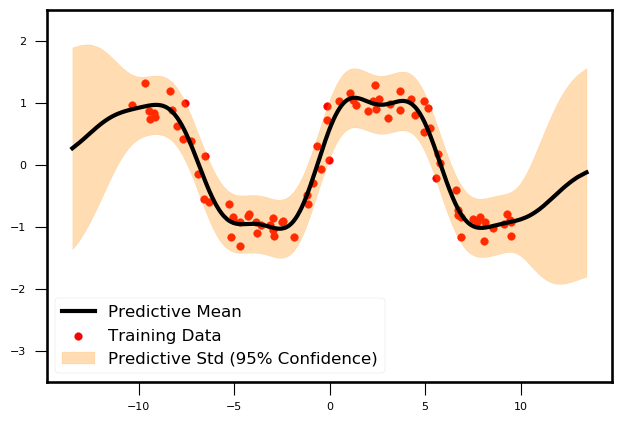

In [28]:
# Uncertainty
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

fig, ax = plt.subplots()

ax.scatter(X, y, c="red", label="Training Data")
ax.plot(
    Xtest.squeeze(),
    mu_y.squeeze(),
    label=r"Predictive Mean",
    color="black",
    linewidth=3,
)
ax.fill_between(
    Xtest.squeeze(),
    mu_y.squeeze() + uncertainty,
    mu_y.squeeze() - uncertainty,
    alpha=0.3,
    color="darkorange",
    label=f"Predictive Std (95% Confidence)",
)
ax.set_ylim([-3.5, 2.5])
ax.legend(fontsize=12)

plt.tight_layout()
fig.savefig(FIG_PATH.joinpath("1d_gp.png"))
# fig.savefig("figures/jaxgp/examples/taylor/1d_gp.png")
plt.show()

### Likelihood Variance

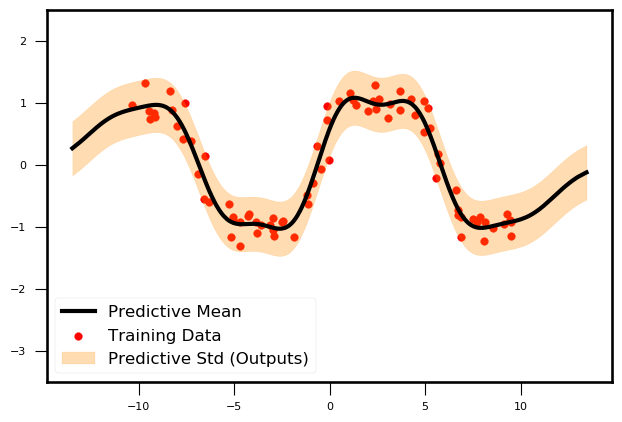

In [29]:
# Uncertainty
uncertainty = 1.96 * jnp.sqrt(var_likelihood.squeeze())

fig, ax = plt.subplots()

ax.scatter(X, y, c="red", label="Training Data")
ax.plot(
    Xtest.squeeze(),
    mu_y.squeeze(),
    label=r"Predictive Mean",
    color="black",
    linewidth=3,
)
ax.fill_between(
    Xtest.squeeze(),
    mu_y.squeeze() + uncertainty,
    mu_y.squeeze() - uncertainty,
    alpha=0.3,
    color="darkorange",
    label=f"Predictive Std (Outputs)",
)
ax.set_ylim([-3.5, 2.5])
ax.legend(fontsize=12)

plt.tight_layout()
fig.savefig(FIG_PATH.joinpath("1d_gp_nout.png"))
# fig.savefig("figures/jaxgp/examples/taylor/1d_gp.png")
plt.show()

### Model Variance

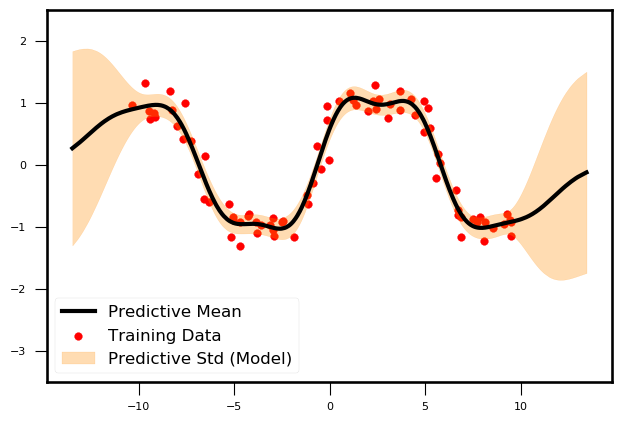

In [30]:

# Uncertainty
uncertainty = 1.96 * jnp.sqrt(var_f.squeeze())
fig, ax = plt.subplots()

ax.scatter(X, y, c="red", label="Training Data")
ax.plot(
    Xtest.squeeze(),
    mu_y.squeeze(),
    label=r"Predictive Mean",
    color="black",
    linewidth=3,
)
ax.fill_between(
    Xtest.squeeze(),
    mu_y.squeeze() + uncertainty,
    mu_y.squeeze() - uncertainty,
    alpha=0.3,
    color="darkorange",
    label=f"Predictive Std (Model)",
)
ax.set_ylim([-3.5, 2.5])
ax.legend(fontsize=12)
plt.tight_layout()
fig.savefig(FIG_PATH.joinpath("1d_gp_nmodel.png"))
# fig.savefig("figures/jaxgp/examples/taylor/1d_gp.png")
plt.show()

